In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

sns.set_style("whitegrid")

In [2]:
# Macro
macro_path = './output/ccar_macro_data_quarterly.csv'

df_macro = pd.read_csv(macro_path)
df_macro['DATE'] = pd.to_datetime(df_macro['DATE'])
df_macro.set_index('DATE', inplace=True)
print(f"Macro Data Loaded: {df_macro.shape}")

Macro Data Loaded: (104, 10)


In [3]:
# Retail
retail_path = './output/jpm_retail_portfolio_raw.csv'

df_retail_raw = pd.read_csv(retail_path)

def fix_quarter_format(q_str):
    match = re.search(r'(\d)Q(\d{2})', str(q_str))
    if match:
        q, yy = match.groups()
        return f"20{yy}Q{q}"
    return q_str

df_retail_raw['Quarter_Fixed'] = df_retail_raw['Quarter'].apply(fix_quarter_format)
df_retail_raw['Quarter_dt'] = pd.PeriodIndex(df_retail_raw['Quarter_Fixed'], freq='Q').to_timestamp(how='end')

df_retail = df_retail_raw.pivot(index='Quarter_dt', columns='Metric', values='Value')

for col in df_retail.columns:
    df_retail[col] = (
        df_retail[col]
        .astype(str)
        .str.replace('%', '', regex=False)
        .str.replace(',', '', regex=False)
        .str.replace('$', '', regex=False)
        .str.strip()
    )
    df_retail[col] = pd.to_numeric(df_retail[col], errors='coerce')

df_retail.index.name = 'DATE'
df_retail = df_retail.resample('QE').mean()
df_retail.index = df_retail.index.normalize()

target_col = 'Net charge-off rate'

if target_col in df_retail.columns:
    df_retail[target_col] = df_retail[target_col].interpolate(method='linear', limit_direction='both')
    print(f"Fixed gap in '{target_col}' using interpolation.")
else:
    print(f"Warning: '{target_col}' not found.")

print(f"Shape: {df_retail.shape}")
print(df_retail[['Net charge-off rate']].head())

Fixed gap in 'Net charge-off rate' using interpolation.
Shape: (67, 23)
Metric      Net charge-off rate
DATE                           
2009-03-31                 2.51
2009-06-30                 3.52
2009-09-30                 3.84
2009-12-31                 3.85
2010-03-31                 4.46


In [4]:
# Merge
df_final = df_retail.join(df_macro, how='inner')

if df_final.empty:
    print("Warning: Merged DataFrame is empty! Check date ranges.")
else:
    print(f"Integration Successful! Final Shape: {df_final.shape}")
    print(f"Time Range: {df_final.index[0].date()} to {df_final.index[-1].date()}")

df_final.to_csv('./output/model_input_combined.csv')

Integration Successful! Final Shape: (67, 33)
Time Range: 2009-03-31 to 2025-09-30


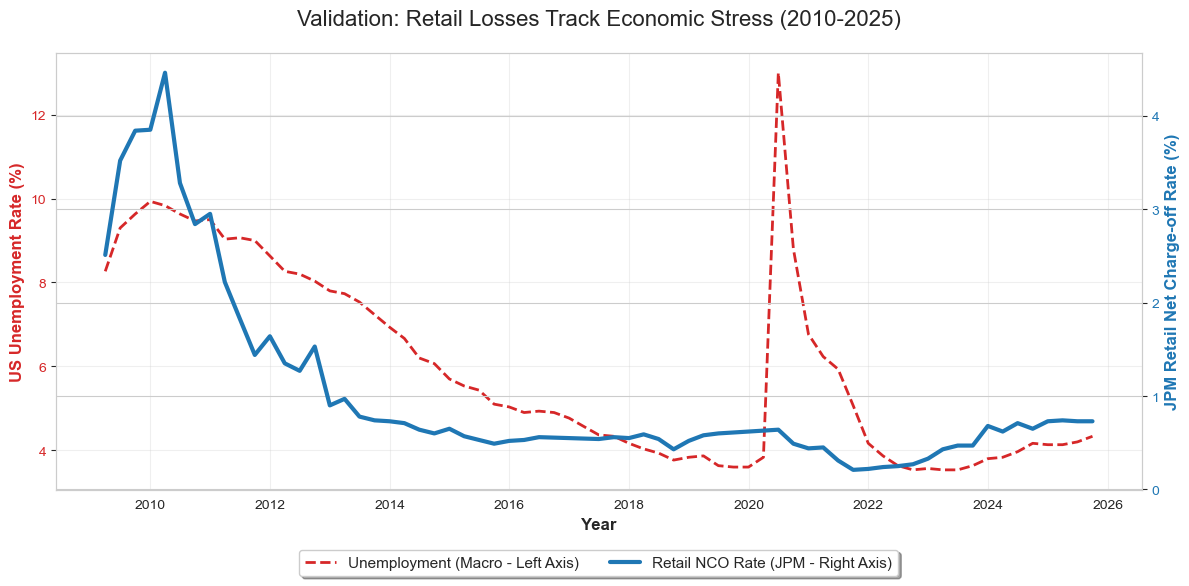

In [5]:
fig, ax1 = plt.subplots(figsize=(12, 6))

target_col = 'Net charge-off rate' 
driver_col = 'Unemployment_Rate'

color_left = 'tab:red'
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('US Unemployment Rate (%)', color=color_left, fontsize=12, fontweight='bold')
l1 = ax1.plot(df_final.index, df_final['Unemployment_Rate'], color=color_left, 
                  linestyle='--', linewidth=2, label='Unemployment (Macro - Left Axis)')
ax1.tick_params(axis='y', labelcolor=color_left)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()  
color_right = 'tab:blue'
ax2.set_ylabel('JPM Retail Net Charge-off Rate (%)', color=color_right, fontsize=12, fontweight='bold')

y_vals = df_final[target_col]
if y_vals.mean() < 1: 
    y_vals = y_vals * 100
    
l2 = ax2.plot(df_final.index, y_vals, color=color_right, 
                linewidth=3, label='Retail NCO Rate (JPM - Right Axis)')
ax2.tick_params(axis='y', labelcolor=color_right)

plt.title('Validation: Retail Losses Track Economic Stress (2010-2025)', fontsize=16, pad=20)
lines = l1 + l2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.12),
            fancybox=True, shadow=True, ncol=2, fontsize=11)

plt.tight_layout()

save_path_1 = './output/chart_trend_validation.png'
plt.savefig(save_path_1, dpi=600, bbox_inches='tight')

plt.show()

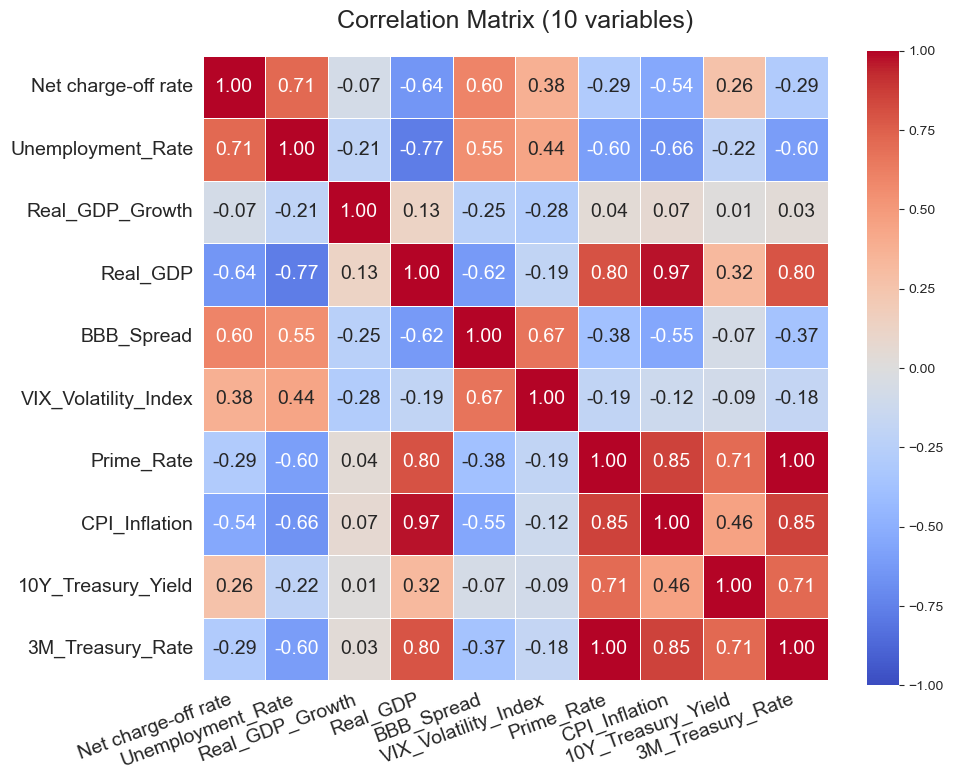

In [19]:
plt.figure(figsize=(10,8))

# For presentation's clarity, just choose some key variables
cols_to_plot = [
        'Net charge-off rate', 
        'Unemployment_Rate',
        'Real_GDP_Growth',
        'Real_GDP',
        'BBB_Spread',
        'VIX_Volatility_Index',    
        'Prime_Rate',             
        'CPI_Inflation',       
        '10Y_Treasury_Yield',    
        '3M_Treasury_Rate'        
    ]
valid_cols = [c for c in cols_to_plot if c in df_final.columns]

if len(valid_cols) > 1:
    corr_matrix = df_final[valid_cols].corr()

    sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 14}, 
                cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1,
                square=True)
    
    plt.title('Correlation Matrix (10 variables)', fontsize=18, pad=20)
    plt.xticks(rotation=20, ha='right', fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    
    plt.tight_layout()
    
    save_path = './output/chart_correlation_matrix_10vars.png'
    plt.savefig(save_path, dpi=600, bbox_inches='tight')

    plt.show()
else:
    print("Not enough columns found for 9-variable heatmap.")

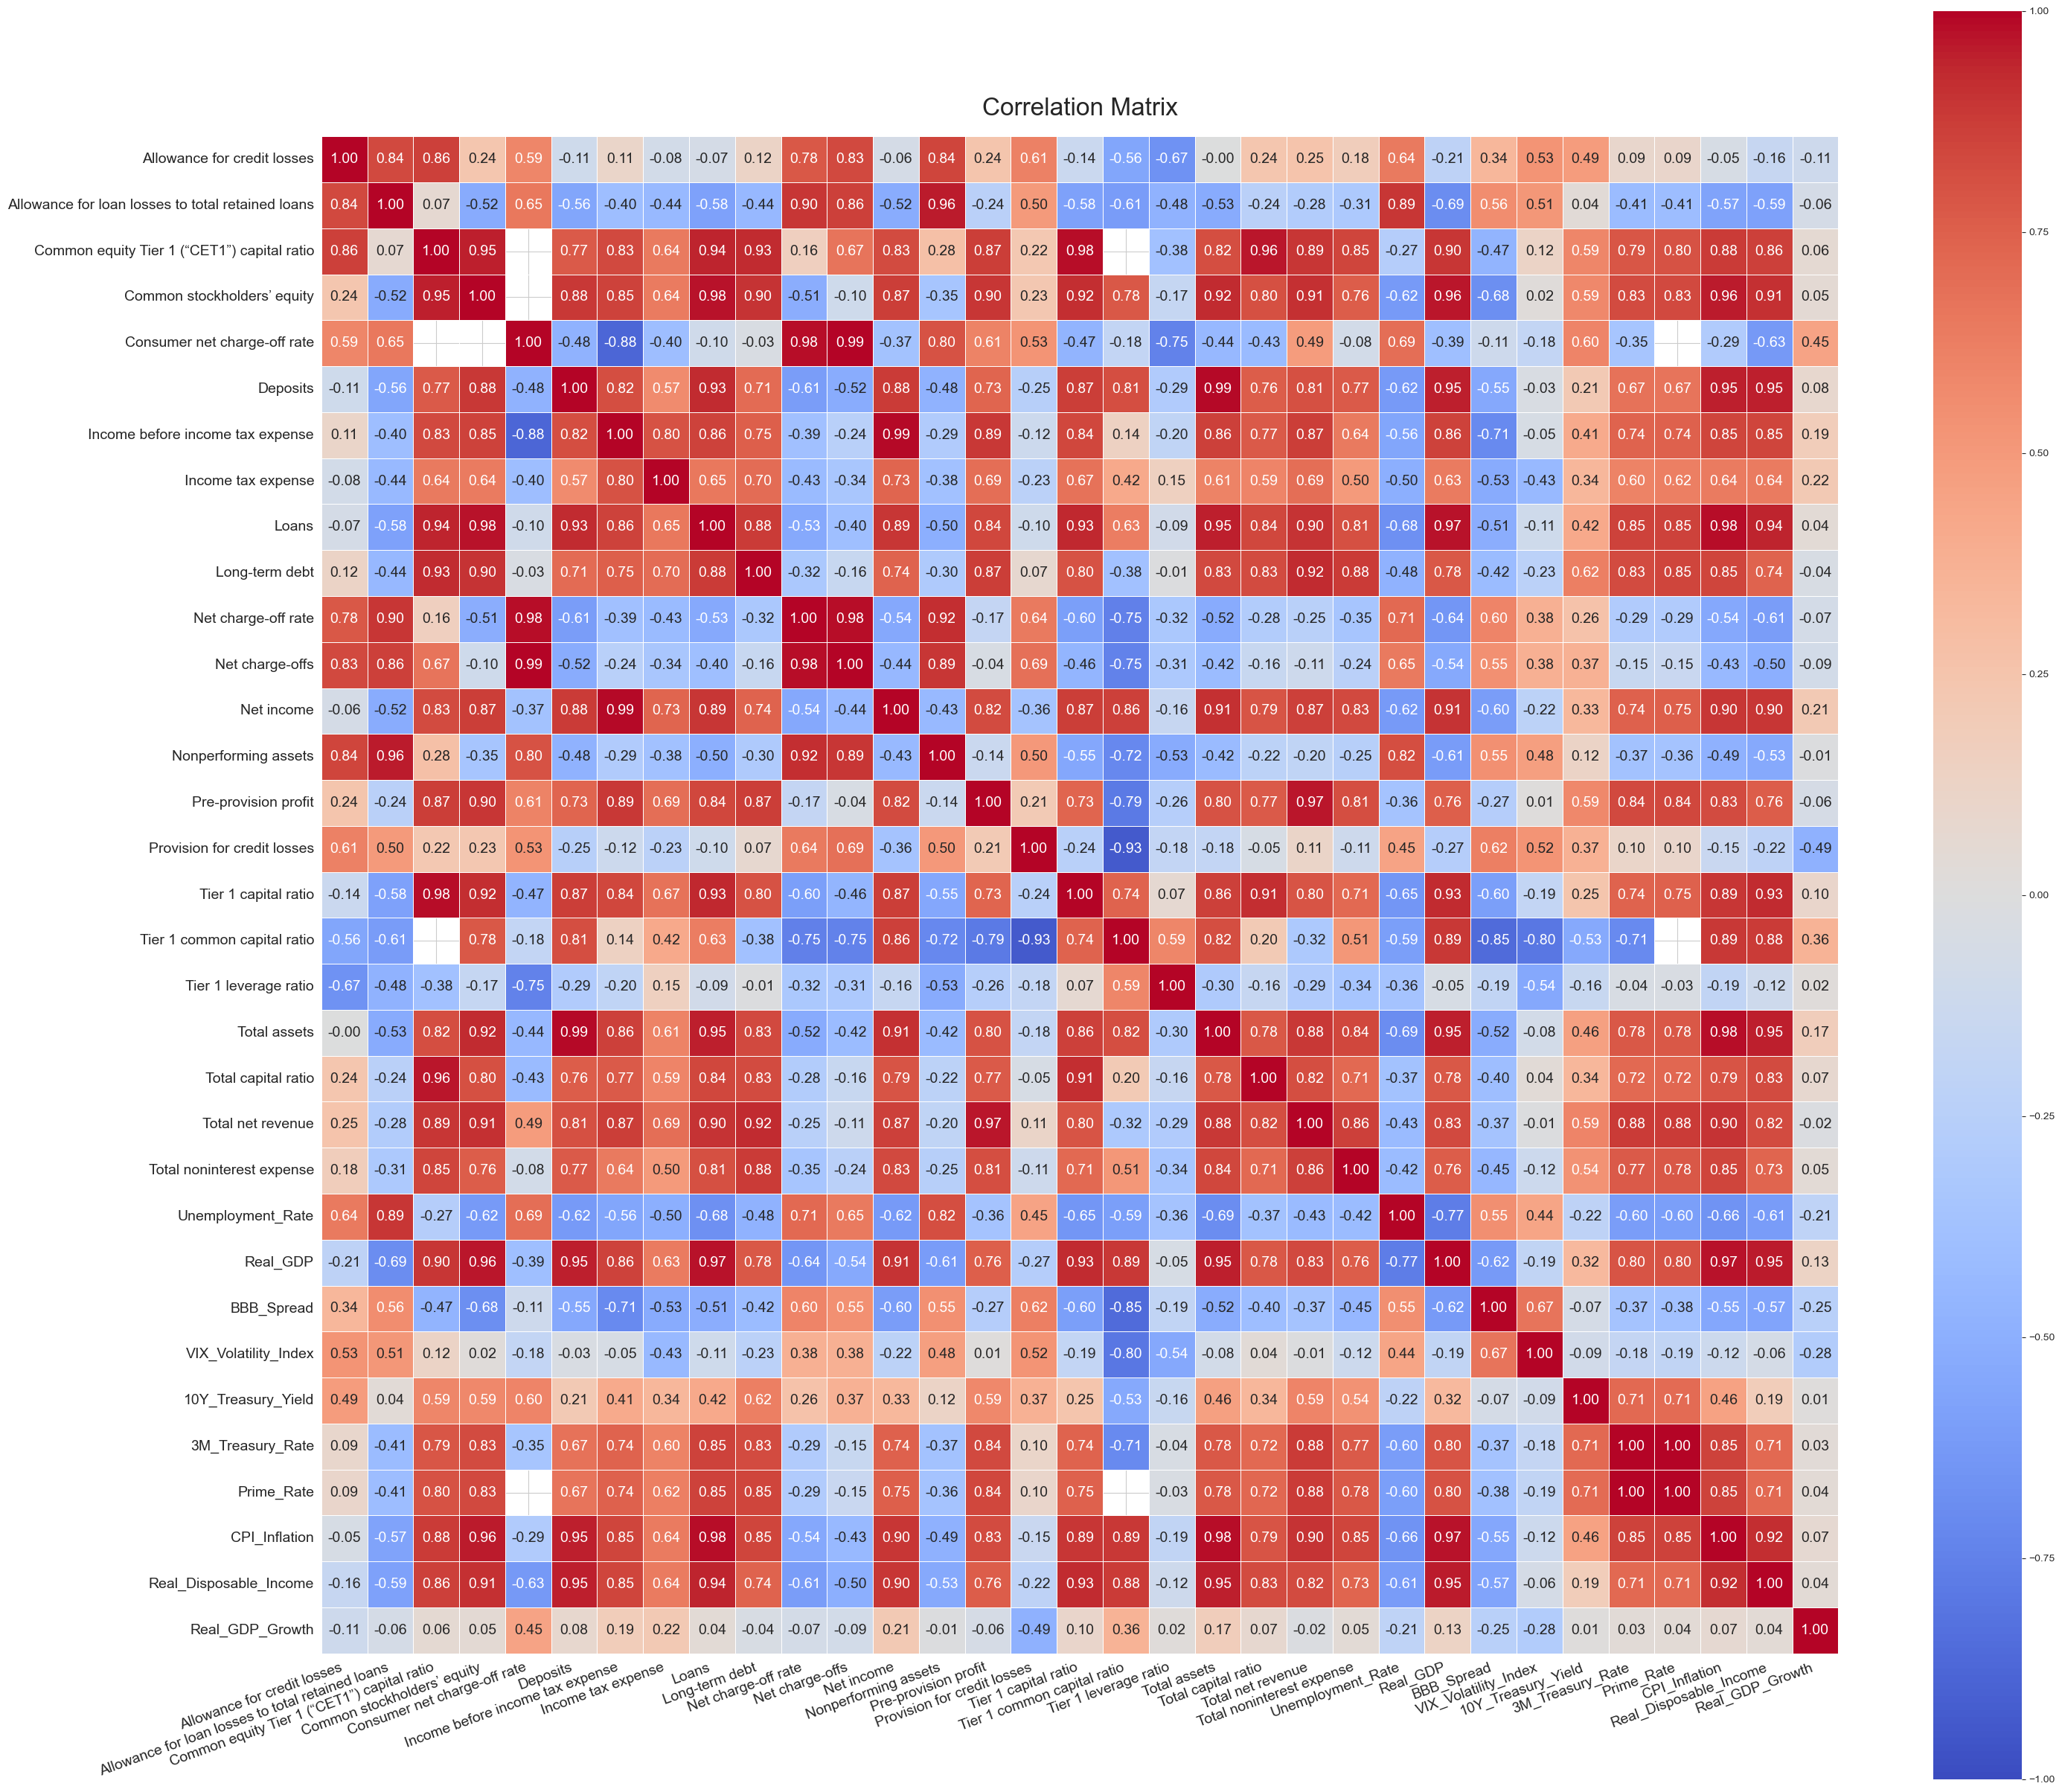

In [7]:
plt.figure(figsize=(30,30))

# Whole Correlation Matrix
corr_matrix_whole = df_final.corr()

sns.heatmap(corr_matrix_whole, annot=True, annot_kws={"size": 14}, 
            cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1,
            square=True, cbar_kws={"shrink": 0.8})

plt.title('Correlation Matrix', fontsize=24, pad=20)
plt.xticks(rotation=20, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)

plt.tight_layout()

save_path = './output/chart_correlation_matrix_whole.pdf'
plt.savefig(save_path, dpi=600, bbox_inches='tight')

plt.show()


--- EDA Summary Statistics ---
                     Count  Mean  Std Dev   Min    Max
Net charge-off rate   67.0  1.01     0.98  0.21   4.46
Unemployment_Rate     67.0  5.93     2.31  3.53  13.00
Real_GDP_Growth       67.0  0.02     0.06 -0.32   0.31
BBB_Spread            67.0  1.95     0.95  0.99   7.03


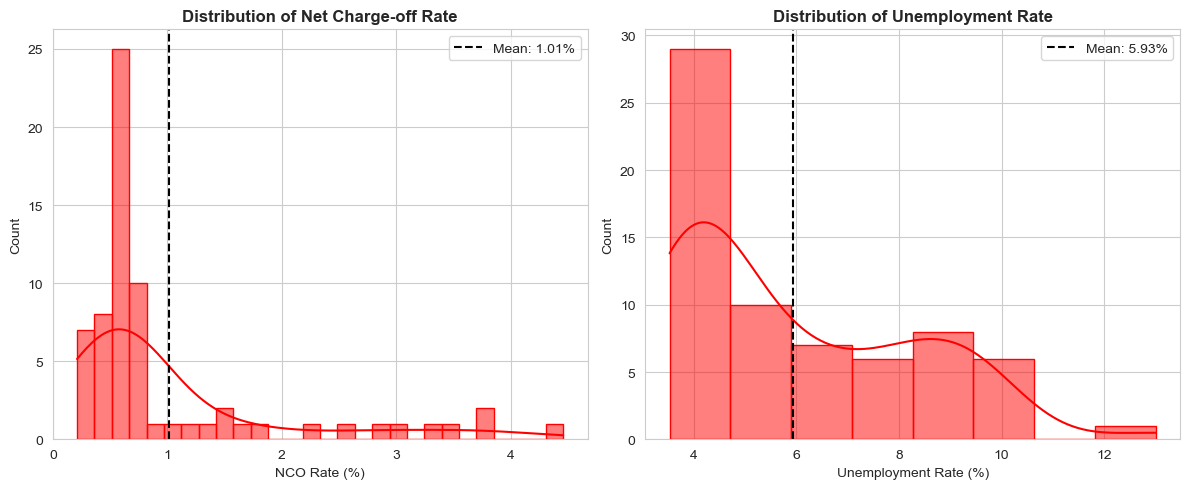

In [8]:
# Descriptive Statistics
cols_to_analyze = ['Net charge-off rate', 'Unemployment_Rate', 'Real_GDP_Growth', 'BBB_Spread']

valid_cols = [c for c in cols_to_analyze if c in df_final.columns]

desc_stats = df_final[valid_cols].describe().T[['count', 'mean', 'std', 'min', 'max']]
desc_stats.columns = ['Count', 'Mean', 'Std Dev', 'Min', 'Max']
print("\n--- EDA Summary Statistics ---")
print(desc_stats.round(2))


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_final['Net charge-off rate'], kde=True, ax=axes[0], color='red', edgecolor='red')
axes[0].set_title('Distribution of Net Charge-off Rate', fontsize=12, fontweight='bold')
axes[0].set_xlabel('NCO Rate (%)')

mean_nco = df_final['Net charge-off rate'].mean()
axes[0].axvline(mean_nco, color='black', linestyle='--', label=f'Mean: {mean_nco:.2f}%')
axes[0].legend()

sns.histplot(df_final['Unemployment_Rate'], kde=True, ax=axes[1], color='red', edgecolor='red')
axes[1].set_title('Distribution of Unemployment Rate', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Unemployment Rate (%)')
mean_unemp = df_final['Unemployment_Rate'].mean()
axes[1].axvline(mean_unemp, color='black', linestyle='--', label=f'Mean: {mean_unemp:.2f}%')
axes[1].legend()

plt.tight_layout()
plt.savefig('./output/chart_eda_distributions.png', dpi=600, bbox_inches='tight')
plt.show()